## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  




2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

## Практическая часть


In [1]:
%matplotlib inline

import lightfm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from lightfm import LightFM

import seaborn as sns

from src import metrics
from src.utils import train_test_split_by_week, group_df_by

/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# import data
# utils functions like in webinar

### Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

### Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [3]:
PATH_TO_DATA = '../урок 2/retail_train.csv'
PATH_TO_USERS_FEATURES_DATA = '../урок 2/hh_demographic.csv'
PATH_TO_ITEMS_FEATURES_DATA = '../урок 2/product.csv'

data = pd.read_csv(PATH_TO_DATA)

users_features = pd.read_csv(PATH_TO_USERS_FEATURES_DATA)
items_features = pd.read_csv(PATH_TO_ITEMS_FEATURES_DATA)

users_features.columns = [column.lower() for column in users_features.columns]
items_features.columns = [column.lower() for column in items_features.columns]

users_features.rename(columns={'household_key': 'user_id'}, inplace=True)
items_features.rename(columns={'product_id': 'item_id'}, inplace=True)

In [4]:
users_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [5]:
items_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
users_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [7]:
def print_uniq_feat(df):
    for column in df.select_dtypes(include='object').columns.values:

        uniques = df[column].unique()

        print('\n')
        print(f'Название столбца: {column}\n')
        print(uniques)
        print('\n' + '*' * 50)

In [8]:
def cat_features_to_num_table(data, cat_features_name):
    
    cat_to_num = {} 
    num_to_cat = {}
    
    for feature in cat_features_name:
        uniq_values = data[feature].unique().tolist()
        num_values = [i for i in range(len(uniq_values))]
        
        cat_to_num_dict = dict(zip(uniq_values, num_values))
        num_to_cat_dict = dict(zip(num_values, uniq_values))
        
        cat_to_num[feature] = cat_to_num_dict
        num_to_cat[feature] = num_to_cat_dict
        
    return cat_to_num, num_to_cat

In [10]:
print_user_uniq_feat = print_uniq_feat(users_features)



Название столбца: age_desc

['65+' '45-54' '25-34' '35-44' '19-24' '55-64']

**************************************************


Название столбца: marital_status_code

['A' 'U' 'B']

**************************************************


Название столбца: income_desc

['35-49K' '50-74K' '25-34K' '75-99K' 'Under 15K' '100-124K' '15-24K'
 '125-149K' '150-174K' '250K+' '175-199K' '200-249K']

**************************************************


Название столбца: homeowner_desc

['Homeowner' 'Unknown' 'Renter' 'Probable Renter' 'Probable Owner']

**************************************************


Название столбца: hh_comp_desc

['2 Adults No Kids' '2 Adults Kids' 'Single Female' 'Unknown'
 'Single Male' '1 Adult Kids']

**************************************************


Название столбца: household_size_desc

['2' '3' '4' '1' '5+']

**************************************************


Название столбца: kid_category_desc

['None/Unknown' '1' '2' '3+']

**********************************

In [11]:
print_items_uniq_feat = print_uniq_feat(items_features)



Название столбца: department

['GROCERY' 'MISC. TRANS.' 'PASTRY' 'DRUG GM' 'MEAT-PCKGD' 'SEAFOOD-PCKGD'
 'PRODUCE' 'NUTRITION' 'DELI' 'COSMETICS' 'MEAT' 'FLORAL'
 'TRAVEL & LEISUR' 'SEAFOOD' 'MISC SALES TRAN' 'SALAD BAR' 'KIOSK-GAS'
 'ELECT &PLUMBING' 'GRO BAKERY' 'GM MERCH EXP' 'FROZEN GROCERY'
 'COUP/STR & MFG' 'SPIRITS' 'GARDEN CENTER' 'TOYS' 'CHARITABLE CONT'
 'RESTAURANT' 'RX' 'PROD-WHS SALES' 'MEAT-WHSE' 'DAIRY DELI' 'CHEF SHOPPE'
 'HBC' 'DELI/SNACK BAR' 'PORK' 'AUTOMOTIVE' 'VIDEO RENTAL' ' '
 'CNTRL/STORE SUP' 'HOUSEWARES' 'POSTAL CENTER' 'PHOTO' 'VIDEO'
 'PHARMACY SUPPLY']

**************************************************


Название столбца: brand

['National' 'Private']

**************************************************


Название столбца: commodity_desc

['FRZN ICE' 'NO COMMODITY DESCRIPTION' 'BREAD' 'FRUIT - SHELF STABLE'
 'COOKIES/CONES' 'SPICES & EXTRACTS' 'VITAMINS' 'BREAKFAST SWEETS'
 'PNT BTR/JELLY/JAMS' 'ICE CREAM/MILK/SHERBTS' 'MAGAZINE' 'AIR CARE'
 'CHEESE' 'SHO

In [12]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [13]:
data_columns = data.columns.values.tolist()
users_features_columns = users_features.columns.values.tolist()
items_features_columns = items_features.columns.values.tolist()

In [14]:
data = data.merge(items_features, how='left', on='item_id')
data = data.merge(users_features, how='left', on='user_id')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,...,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,...,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data_train, data_test = train_test_split_by_week(data, 'week_no', 3)

In [ ]:
def catplots(data, feats_list)

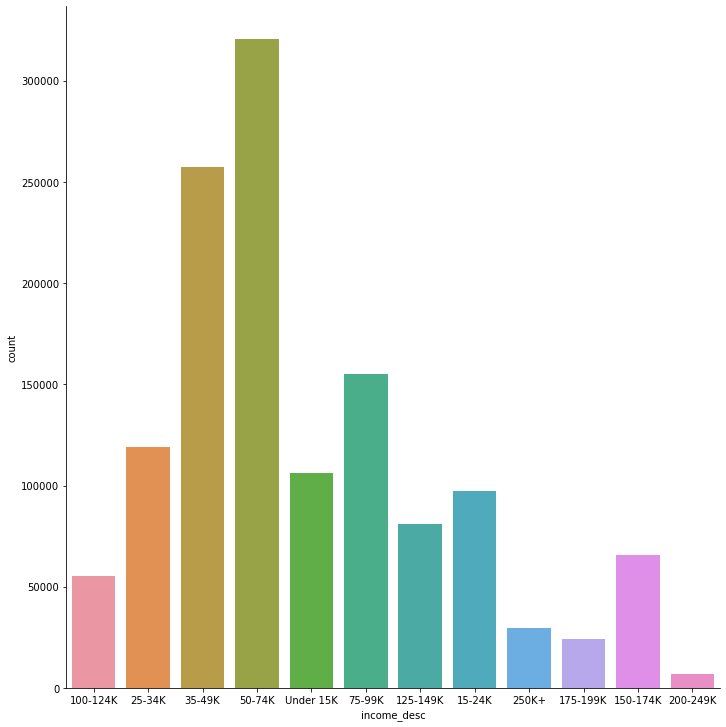

In [33]:
sns.catplot(data=data, x='income_desc', kind='count', height=10)

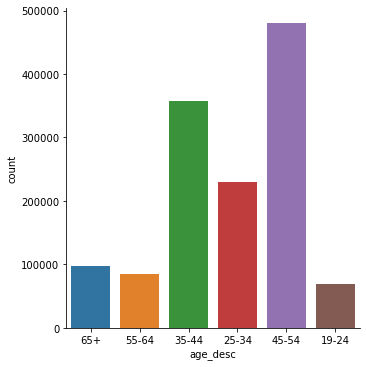

In [35]:
sns.catplot(data=data, x='age_desc', kind='count', height=5)

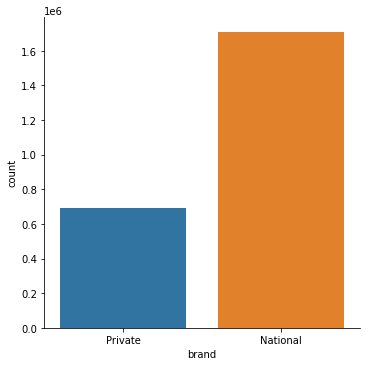

In [37]:
sns.catplot(data=data, x='brand', kind='count', height=5)

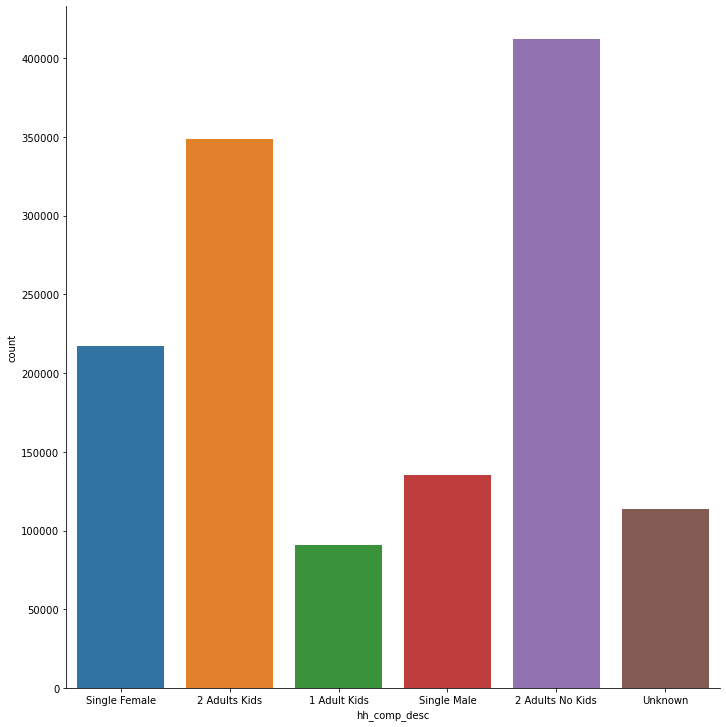

In [39]:
sns.catplot(data=data, x='hh_comp_desc', kind='count', height=10)

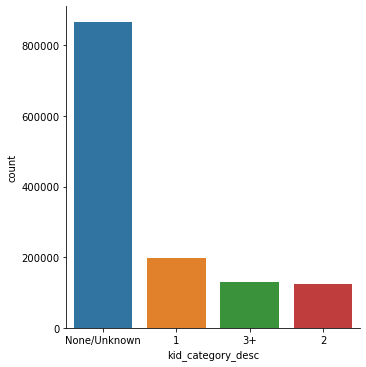

In [40]:
sns.catplot(data=data, x='kid_category_desc', kind='count')

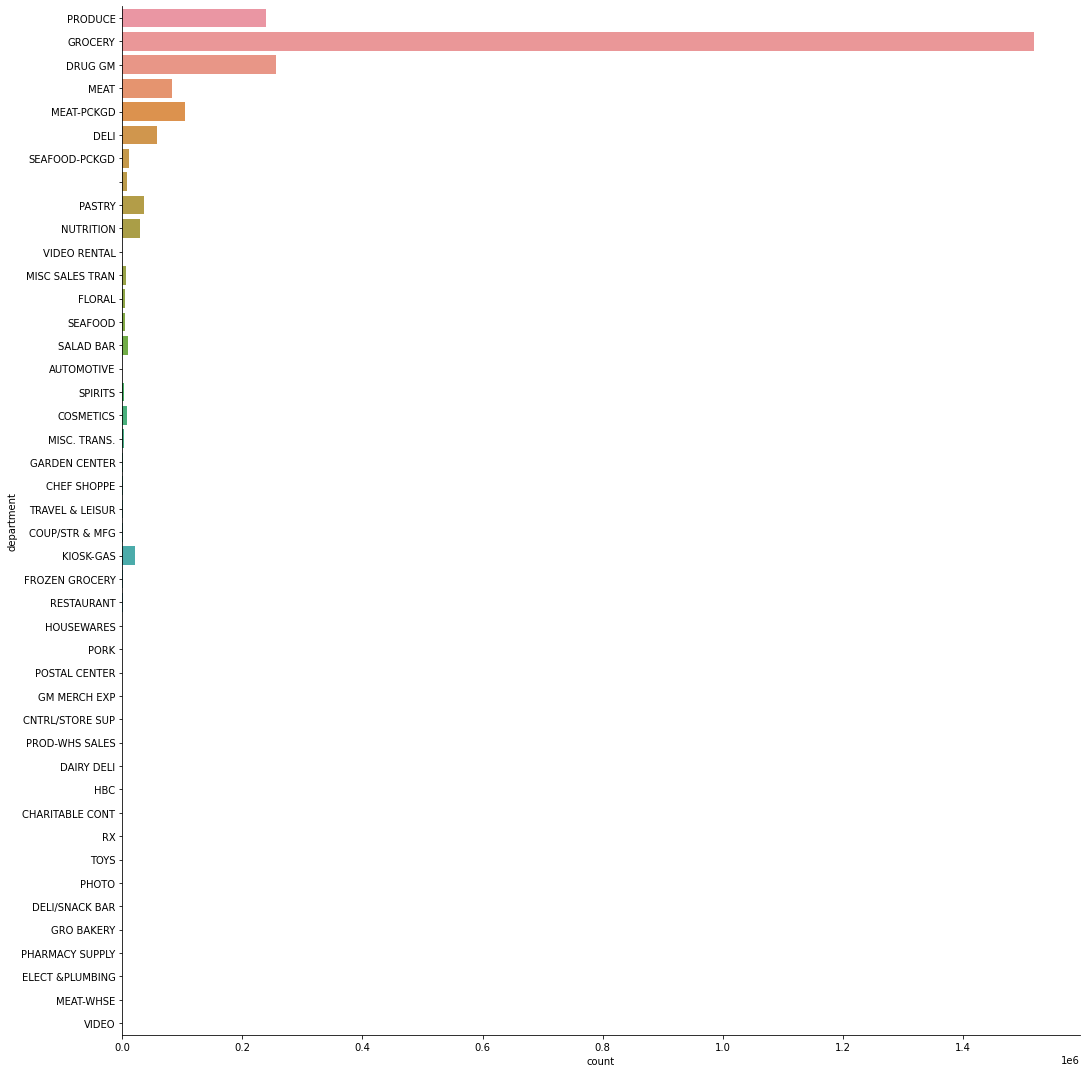

In [45]:
sns.catplot(data=data, y='department', kind='count', height=15)

In [51]:
big_features = ['GROCERY', 'PRODUCE', 'DRUG GM', 'MEAT', 'MEAT-PCKGD', 'DELI', 'PASTRY', 'NUTRITION']

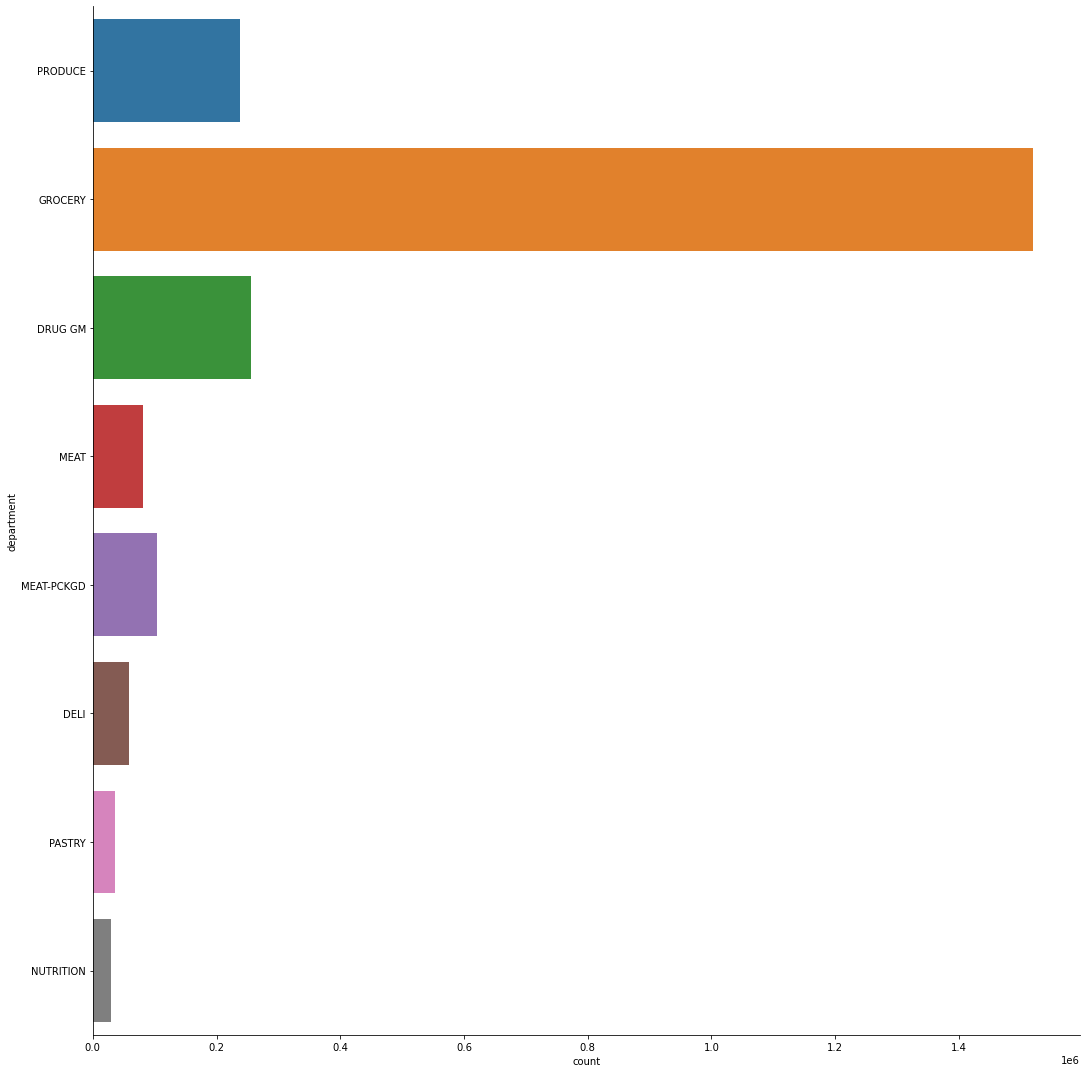

In [52]:
sns.catplot(data=data.loc[data['department'].isin(big_features)], y='department', kind='count', height=15)

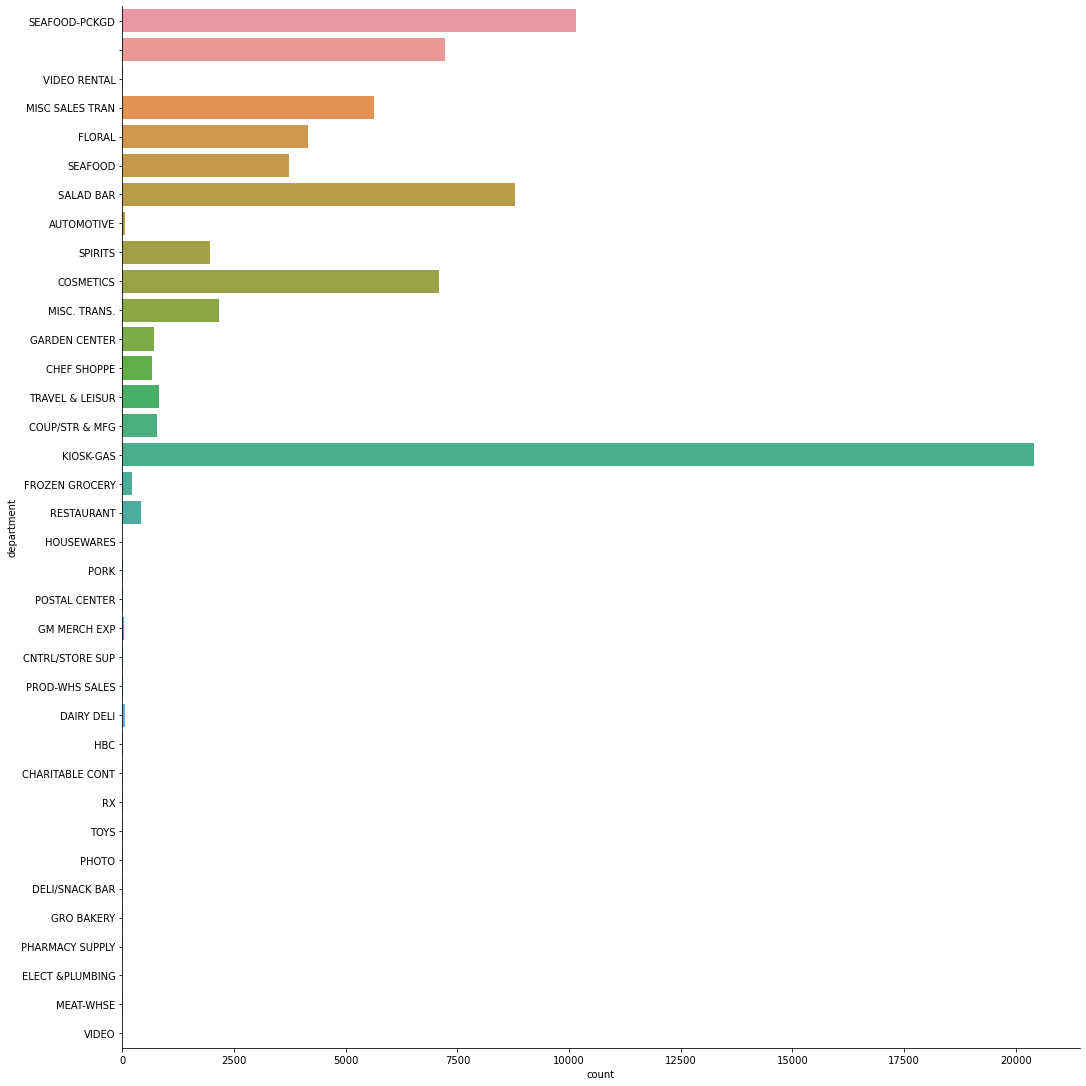

In [53]:
sns.catplot(data=data.loc[~data['department'].isin(big_features)], y='department', kind='count', height=15)

In [55]:
data.loc[data.income_desc.isin(['100-124K', '250K+', '175-199K' '200-249K'])].sort_values('quantity', ascending=False)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
468356,2407,29392047893,181,6544236,85055,210.00,375,-8.51,1606,27,...,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,45-54,A,100-124K,Homeowner,2 Adults No Kids,2,None/Unknown
2302438,2328,41366409117,641,6544236,35836,87.76,406,-5.38,1351,92,...,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,45-54,U,250K+,Homeowner,2 Adults No Kids,2,None/Unknown
2124167,1228,40679895034,598,6534178,35077,76.78,327,-0.01,617,86,...,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown
2048351,1228,40447620542,577,6534178,34228,69.11,327,-3.42,1117,83,...,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown
1870424,2133,35727256342,533,6534178,32623,75.00,433,-3.26,1535,77,...,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,55-64,A,100-124K,Unknown,2 Adults No Kids,2,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360237,2407,28970490045,153,1069990,0,0.00,429,0.00,607,23,...,DINNER SAUSAGE,SMOKED/COOKED,16 OZ,45-54,A,100-124K,Homeowner,2 Adults No Kids,2,None/Unknown
1242514,413,32589571014,377,5978648,0,0.00,448,0.00,1425,55,...,,,,45-54,U,100-124K,Unknown,Unknown,1,None/Unknown
1031168,2264,31832862474,325,5978648,0,0.00,442,0.00,2120,47,...,,,,45-54,A,250K+,Homeowner,2 Adults No Kids,2,None/Unknown
370024,1557,29034636346,156,1049876,0,0.00,450,0.00,1430,23,...,SHAVING CARE PRODUCTS,MENS HAIR SPRAYS/TONICS/CREAMS,4.5 OZ,25-34,A,100-124K,Renter,1 Adult Kids,4,2


In [56]:
data['quantity'].max()

89638

### LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  
У Вас, скорее всего, возникнет проблема со временем обучения. Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

In [ ]:

model = LightFM(no_components=5, 
                loss='bpr', 
                learning_rate=5e-2, 
                item_alpha=1e-1, 
                user_alpha=1e-1, 
                random_state=42)

model.fit()

### *Отбор признаков* * 

Все данные категориальные, при ohe кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

*задание необязательно
